##### from numpy import append, exp, sin, pi, fromiter, binary_repr, int_, roll, dot
from numpy.random import rand, randn
from matplotlib.pyplot import figure, plot, subplot, hist

from IPython.display import HTML

In [2]:
display(HTML(open('Slides.css').read()))  #load the CCS style sheet

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


<center> <h1> STOCHASTIC DECAY </h1> </center>
<br><br><br>


<div style="text-align: right;">André van Schaik<br>June 2015</div>

This notebook reports on a method of implementing long time constants in hardware using state-variables encoded with a limited number of bits. This situation occurs, for example, when simulating a neural network with many millions of neurons using time multiplexing on an FPGA. With a standard Finite Impulse Response (IIR) filter approach, a large number of bits would be needed for each state variable to give each the resolution to calculate long time constants. But each state variable would need to be stored in memory, which is limited on an FPGA and which introduces a communication bottleneck, since only a few bits can be exchanged with the memory in a single clock cycle.

# Discrete time filtering

In the standard discrete time filtering approach, the continuous time equation is discretised:

$$\begin{align*} 
\frac{\mathrm d V}{\mathrm d t} &= -\frac{V}{\tau} \\
V &= -\tau \frac{\mathrm d V}{\mathrm d t}\\
V[t] &= -\tau \frac{V[t] - V[t-1]}{\mathrm \Delta t} \\
V[t] (1 + \frac{\tau}{\Delta t}) &= \frac{\tau}{\Delta t}V[t-1] \\
V[t] &= \frac{\tau}{\Delta t + \tau}V[t-1] \\
\end{align*}$$

If $\tau$, the time constant, is expressed in clock cycles, then $\Delta t = 1$, so the equation becomes:

$$V[t] = a \times V[t-1]$$
where
$$a = \frac{\tau}{\tau+1}$$

When $\tau$ is large, $a$ is only a little less than 1, and a large number of bits are needed to encode its value accurately. If the number of bits used to encode $V$ is equal to, or less than, the number of bits used to encode $a$, the above recursive multiplication just results in a near linear decay. This is shown below for $V$ encoded with 6 bits:

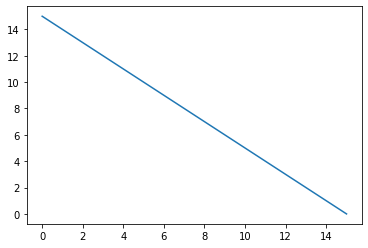

In [4]:
# using integers only mimics using a limited number of bits
nbits = 10
r = 2**nbits

tau = 19
a = (tau*r) // (tau+1)

V = 15
Vout = V
while V>0:
    V = a * V//r
    Vout = append(Vout,V)
    
plot(Vout);

Thus, to approximate an exponential decay, the number of bits in $V$ would need to be large too. Here both $a$ and $V$ are encoded using 10 bits:

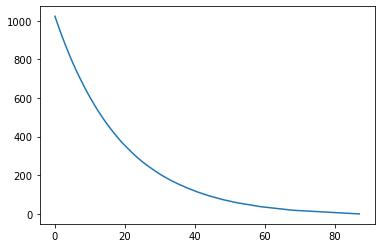

In [5]:
# using integers only mimics using a limited number of bits
nbits = 10
r = 2**nbits

tau = 19
a = (tau*r)//(tau+1)

V = 1023
Vout = V
while V>0:
    V = a*V//r
    Vout = append(Vout,V)
    
plot(Vout);

In [6]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

The **half-time** $h$ is the time it takes for $V$ to decay to half its initial value. For an IIR filter this is given by:

$$ \begin{align*} 
\frac{V}{2} &= a^h V = \left(\frac{\tau}{\tau+1}\right)^h V \\
\frac{1}{2} &= \left(\frac{\tau}{\tau+1}\right)^h \\
-1 &= h\, log2(\frac{\tau}{\tau+1}) \\
-1 &= h \frac{ln(\frac{\tau}{\tau+1})}{ln(2)} \\
h &= -\frac{ln(2)}{ln(\frac{\tau}{\tau+1})} \\
h &=\frac{-ln(2)}{-ln(1+\frac{1}{\tau})} \\
h &\approx \tau \, ln(2) 
\end{align*} $$

# Bernouilli trials

If, instead of storing $V$ in high resolution as needed for an IIR filter, at each clock cycle $V$ is decremented by 1 according to a Bernouilli trial with a probability $p = V/\tau$ (for $V \le \tau$), the number of cycles $n$ it takes for $V$ to decrement is given by the Geometric distribution:

$$ P(n) = (1-p)^{n-1}p $$

The expected value for $n$ is then given by:

$$ E(n) = \frac{1}{p} = \frac{\tau}{V} $$

Thus, since the next time to decay is independent of the previous decay time, the expected value for the duration $N$ for $V$ to decrement $k$ times is given by:

$$ \begin{align*} 
E(N|k) &= \frac{\tau}{V} + \frac{\tau}{V-1} + \dotsb + \frac{\tau}{V+1-k} \\ 
     &= \sum_{i=1}^k \frac{\tau}{V+1-i} \\
\end{align*}$$


The Expected value for the half-time, $h$, is simply the time it takes for $V$ to decrement $V/2$ times:

$$ \begin{align*} 
E(h) &= \sum_{i=1}^{V/2} \frac{\tau}{V+1-i} \\
    &= \tau \sum_{i=1}^{V/2} \frac{1}{V/2+i} \\
\end{align*}$$

In this, the sum converges to $ln(2)$ as $V/2 \to \infty$, so that we can write: 

$$ E(h) \approx \tau \, ln(2) $$

which shows the equivalence with the half-time in an IIR filter. 

Here we compare an IIR filter with floating point resolution with a stochastic decay where $V$ is stored using only 4 bits, $\tau$ is a 5-bit constant, and a 10-bit **Linear Feedback Shift Register** (LFSR) is used to generate random numbers.

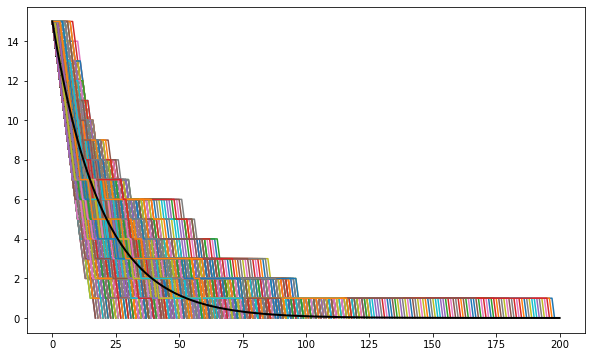

In [7]:
def LFSR_10bit (lfsr_i):
        lfsr_o = roll(lfsr_i,1)
        lfsr_o[3] = lfsr_o[3]^lfsr_o[0]
        return lfsr_o

def dec2bin (N_bits,number):
    return fromiter((a for a in binary_repr(number,N_bits)), dtype=int_)[::-1]

def bin2dec (N_bits,number):
    return dot(number,fromiter((2**x for x in range(N_bits)), dtype=int_))

def stochastic_decay(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    beta = 2**10/tau                            # 0 < tau <= 2**9, thus beta in range [2,2**10]
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    V_int = V_init                              # reset initial voltage
    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        V_int -= bin2dec(10, lfsr) < beta * V_int    # decrement based on random value in lfsr
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    Vs = append(Vs,0)                           # add a final 0 to trace for plotting
    return Vs                                


fig = figure()
fig.set_size_inches(10,6)

tau = 19                                        # time constant in units of dt
a = tau/(tau+1.)                                # IIR multiplication constant
V_init = 15                                     # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = stochastic_decay(V_init, tau, seed)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k', linewidth=2);                      # plot IIR trace (once)



In [8]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

The variance for the half-time is given by the sum of the variances for each decrement, since each duration until a decrement is an independent random variable. The variance for a single decrement is given by:

$$ Var(n) = \frac{1-p}{p^2} = \frac{1-V/\tau}{V^2/\tau^2} = \frac{\tau^2}{V^2} - \frac{\tau}{V} = \frac{\tau^2}{V^2} - E(n) $$

Accordingly, the variance for the half-time, $h$, is given by:

$$\begin{align*}
Var(h) &= \sum_{i=1}^{V/2} \frac{\tau^2}{(V+1-i)^2} - \frac{\tau}{V+1-i} \\
    &= \sum_{i=1}^{V/2} \frac{\tau^2}{(V+1-i)^2} - \sum_{i=1}^{V/2} \frac{\tau}{V+1-i} \\
    &= \sum_{i=1}^{V/2} \frac{\tau^2}{(V/2+i)^2} - E(h) \\
    &\approx \frac{\tau^2}{V+1} - \tau \, ln(2) \\
\end{align*}$$

# Extension to $V > \tau$

When $V > \tau$, $p > 1$, which is then not a probability anymore. However, one can simply decay $V$ by the integer part of $V/\tau$, and use the remainder as $p$. Then, at each time step we have the following decay, $d$:

$$ d = \frac{V}{\tau} \approx int(\frac{V}{\tau}) + X $$

$$ P(X=1) = (\frac{V}{\tau})\%1 $$

where $z\%1$ is $z$ modulo 1, $int(V/\tau)$ is the integer part of $V/\tau$, and $X$ is a random binary variable.

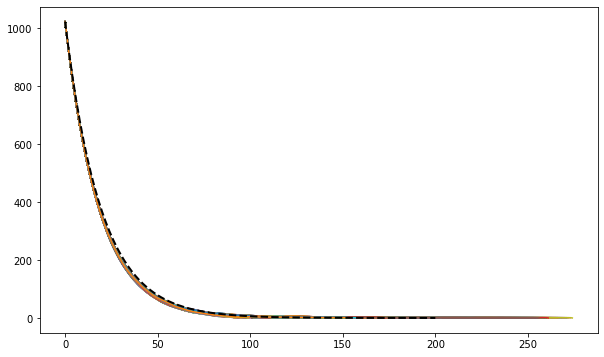

In [9]:
def stochastic_decay2(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    V_int = V_init                              # reset initial voltage
    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        beta = 1.0*V_int/tau                    # get value of derivative at current V
        V_int -= bin2dec(10, lfsr) < 2**10 * (beta%1)  # stochastic part of decrement
        V_int -= int(beta)                      # deterministic part of decrement
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    Vs = append(Vs,0)                           # add a final 0 to trace for plotting
    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.)                                # IIR multiplication constant
V_init = 1023                                   # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = stochastic_decay2(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)



In [10]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

At first this looks OK, but when you zoom in, you can see it decays too quickly:

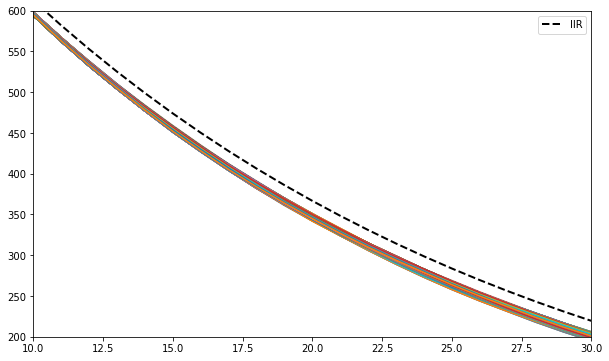

In [11]:
ax.set_xlim((10,30))
ax.set_ylim((200,600))
ax.legend()
display(fig)

This comes from the fact that effectively we are doing a forward Euler integration where we evaluate the derivative at the current time step, and then decrement by that value. However, this value always overestimates how much $V$ will decrease in one time step for a decaying exponential. 

A much better solution is obtained by applying the above approach of splitting the integer and fractional part of the decay to: 

$$ d = \frac{V}{\tau+1} \approx int(\frac{V}{\tau+1}) + X $$

$$ P(X=1) = (\frac{V}{\tau+1})\%1 $$


This shows immediate parallels with the original IIR filter for which we had:

$$V[t+1] = a \times V[t]$$
where
$$a = \frac{\tau}{\tau+1}$$
which gives for the decay:
$$V[t] - V[t+1] = \frac{V[t]}{\tau+1}$$



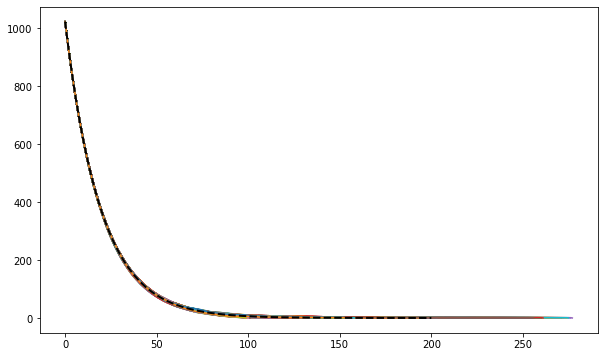

In [12]:
def stochastic_decay2(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    V_int = V_init                              # reset initial voltage
    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        beta = 1.0*V_int/(tau+1)                # corrected Euler integration
        V_int -= bin2dec(10, lfsr) < 2**10 * (beta%1)  # stochastic part of decrement
        V_int -= int(beta)                      # deterministic part of decrement
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    Vs = append(Vs,0)                           # add a final 0 to trace for plotting
    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.)                                # IIR multiplication constant
V_init = 1023                                   # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = stochastic_decay2(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)


In [13]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

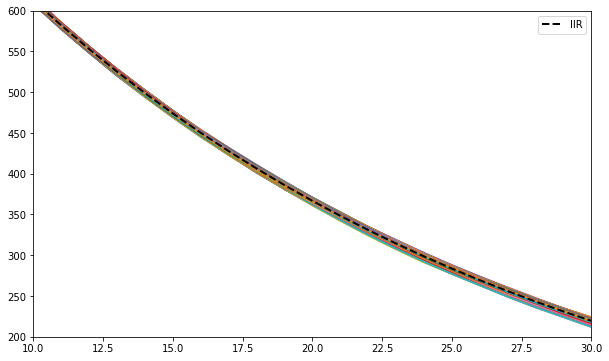

In [14]:
ax.set_xlim((10,30))
ax.set_ylim((200,600))
ax.legend()
display(fig)

# Mark's version

An alternative implementation is obtained by adding a random fraction, $r$, to the integer $V$, multiplying this by the IIR constant, $a$, and only storing the integer part of this. 

For example, if $V$ is stored as a 4-bit integer, $r$ is a 10-bit random fraction, and $a$ is also stored as a 10-bit fraction, you are multiplying a 14-bit number with a 10-bit number and storing only the 4 MSBs of the 24-bit result. 

This needs a bigger multiplier than the previous implementation, but we don't need to subtract integer values from $V$. Note that adding $r$, a fraction, to $V$ an integer, doesn't need an adder. Instead you can just concatenate the bits.

Mathematically, the method can be written as:

$$ V[t+1] = int\left(\frac{\tau}{\tau+1}(V[t] + r[t])\right) $$

where $r[t]$ is a random number drawn from a uniform distribution in the range (0,1). This is effectively a form of dithering to deal with the rounding of $V$ to an integer value.

The probability of **not** decaying, i.e., $(1-p)$, is then given by:

$$ \frac{1}{\tau+1}V \le \frac{\tau}{\tau+1}r $$

$$ r \ge \frac{V}{\tau} $$

$$ p = \frac{V}{\tau} $$

The actual decay is given by:

$$\begin{align*}
d &= V[t] - V[t+1] \\
&= V[t] - int\left(\frac{\tau}{\tau+1}(V[t] + r[t])\right) \\
&= int\left(V[t] - \frac{\tau}{\tau+1}(V[t] + r[t])\right) \\
&= int\left(\frac{V[t]}{\tau+1} - \frac{\tau}{\tau+1}r[t]\right)
\end{align*}$$

Since $\frac{\tau}{\tau+1}r[t] < \frac{\tau}{\tau+1} < 1$, $d$ is either $int(\frac{V[t]}{\tau+1})$, or $int(\frac{V[t]}{\tau+1}) - 1$. The former happens when: 

$$ \frac{V[t]}{\tau+1} - int(\frac{V[t]}{\tau+1}) = \frac{V[t]}{\tau+1}\%1 > \frac{\tau}{\tau+1}r[t] $$

which has a probability:

$$ p = \frac{\tau+1}{\tau}\left(\frac{V[t]}{\tau+1}\%1\right) $$

Hence we can rewrite this as:

$$ d =  int(\frac{V}{\tau+1}) + X $$

$$ P(X=1) = \frac{\tau+1}{\tau}\left(\frac{V[t]}{\tau+1}\%1\right) $$

This is not quite what we had before, but when $\frac{\tau+1}{\tau}$ is close to 1, the difference is small. In the simulation below we deliberately choose a small $\tau$ of 3, so that $p$ is 30% larger than it should be.

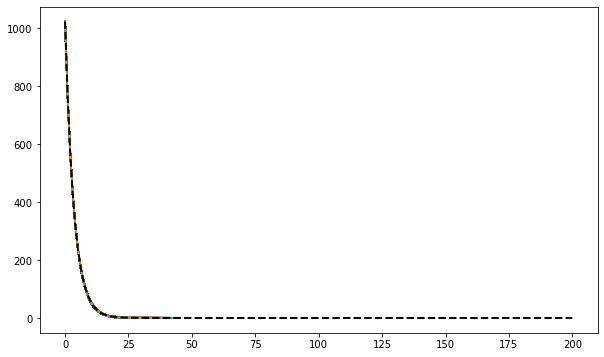

In [15]:
def stochastic_decay_RW(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    V_int = V_init                              # reset initial voltage
    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        r = bin2dec(10,lfsr)/2.**10
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        V_int = int((V_int+r)*a)                # add random fraction and multiply with IIR factor
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    Vs = append(Vs,0)                           # add a final 0 to trace for plotting
    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 3                                         # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
V_init = 1023                                   # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = stochastic_decay_RW(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)


In [16]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

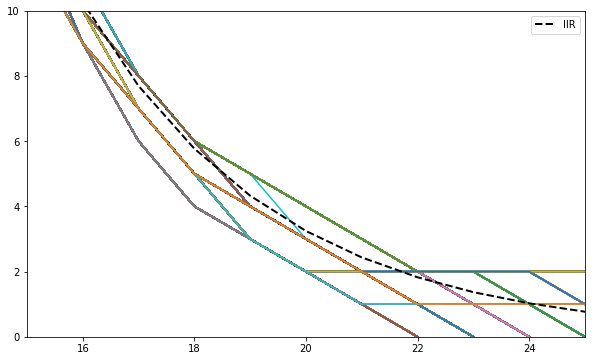

In [17]:
ax.set_xlim((15,25))
ax.set_ylim((0,10))
ax.legend()
display(fig)

# Mark Mark 2

Even with such a small $\tau$, the effect of $p$ being too large is very minor. However, the correct solution can be obtained by a simple modification - we first multiply $V$ by the IIR factor and then adding the random variate $r$:

$$ V[t+1] = int\left(\frac{\tau}{\tau+1}V[t] + r[t]\right) $$


The decay is then given by:

$$\begin{align*}
d &= V[t] - V[t+1] \\
&= V[t] - int\left(\frac{\tau}{\tau+1}V[t] + r[t]\right) \\
&= int\left(\frac{V[t]}{\tau+1} - r[t]\right) \\
&= int(\frac{V}{\tau+1}) + X 
\end{align*}$$

where

$$ P(X=1) = \frac{V[t]}{\tau+1}\%1 $$

which is what we want. However, now you do need an adder to add $r$ to $aV$ after doing the multiplication.

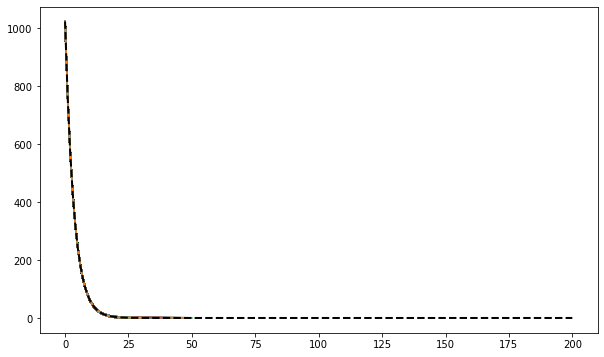

In [18]:
def stochastic_decay_RW2(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    V_int = V_init                              # reset initial voltage
    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        r = bin2dec(10,lfsr)/2.**10
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        V_int = int(V_int*a+r)                  # add random fraction and multiply with IIR factor
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    Vs = append(Vs,0)                           # add a final 0 to trace for plotting
    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 3                                         # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
V_init = 1023                                   # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = stochastic_decay_RW2(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)


In [19]:
HTML('''<div style="text-align:right; font-size:50%">
<a href="javascript:code_toggle()">toggle code</a></div>''')

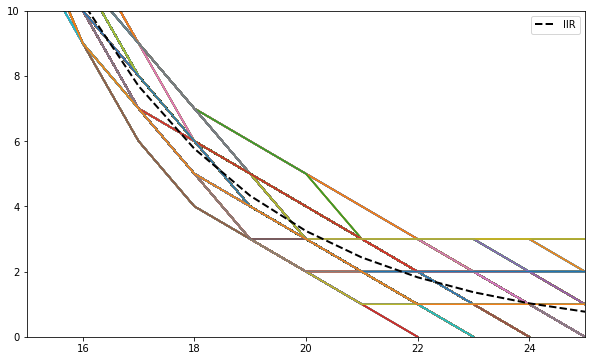

In [20]:
ax.set_xlim((15,25))
ax.set_ylim((0,10))
ax.legend()
display(fig)

# Low-Pass Filter

We can also apply this method to create a low-pass filter. The IIR equation for a first order low-pass filter is:

$$ V[t] = a V[t-1] + (1-a) V_{in} $$

Just as we stochastically decide to decay with probability $p=a$, we could decide to stochastically add $V_{in}$ to $V$ with probability $p=(1-a)$. However, since $(1-a)$ is typically close to 0, this would effectively result in severely reducing the sample rate of the input signal.

A better solution is found by rewriting the filter equation as:

$$ V[t] = a (V[t-1] - V_{in}) + V_{in} $$

In this case, every sample of $V_{in}$ is used. Note that now, even if $V$ and $V_{in}$ are unsigned integers, the term in brackets will be negative when $V < V_{in}$, and the multiplier will need to be able to handle this.

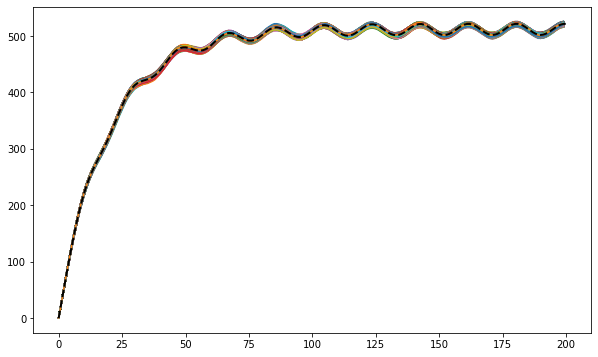

In [21]:
def V_in(t):
#    V = 512
    V = 512 + 64*sin(2*pi*t/19)
    return V

def LPF(V_init = 15, tau = 19, seed = 123, V_bits = 4, dur = 200):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    Vs = []                                     # reset stochastic decay trace
    for t in range(dur):                        # simulate dur time steps
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        r = bin2dec(10,lfsr)/2.**10
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vs = append(Vs,V_int)                   # append to current trace
        Vin = V_in(t)
        V_int = int((V_int-Vin)*a + Vin + r)    # LPF equation
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
V_init = 0                                      # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = LPF(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a + V_in(t)*(1-a)                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)

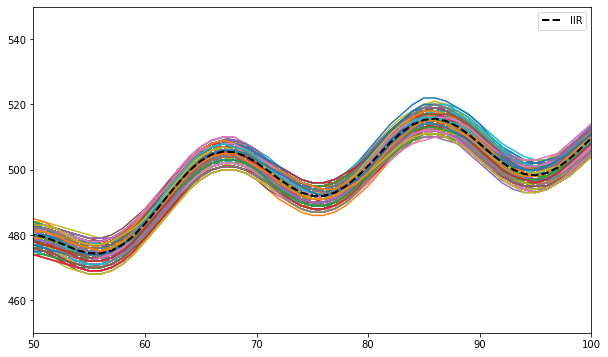

In [22]:
ax.set_xlim((50,100))
ax.set_ylim((450,550))
ax.legend()
display(fig)